In [1]:
import datarobot as dr
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
print(sns.__version__)

0.12.0


## Load data

In [2]:
intent_model_preds_dataset_id = '6750c04ba26a792e4929df9a'
churn_model_preds_dataset_id = '6750b2c65ad144f071ab9940'

In [3]:
intent_df_preds = dr.Dataset.get(intent_model_preds_dataset_id).get_as_dataframe(low_memory=True)
churn_df_preds = dr.Dataset.get(churn_model_preds_dataset_id).get_as_dataframe(low_memory=True)
# print(intent_df_preds, churn_df_preds)
print(intent_df_preds.shape, churn_df_preds.shape)

(1601757, 13) (368611, 6)


In [41]:
print("Prediction date for intent model:", set(intent_df_preds['observation_date'].values))
print("Prediction date for churn model:", set(churn_df_preds['inference_date'].values))

Prediction date for intent model: {'2024-08-04'}
Prediction date for churn model: {'2024-08-04'}


In [4]:
intent_df_preds.columns

Index(['churned_1_PREDICTION', 'churned_0_PREDICTION', 'churned_PREDICTION',
       'THRESHOLD', 'POSITIVE_CLASS', 'DEPLOYMENT_APPROVAL_STATUS',
       'prediction_status', 'idsubscrip', 'idsystem', 'pubcode',
       'observation_date', 'churned', 'stop_intent_date'],
      dtype='object')

In [5]:
churn_df_preds.columns

Index(['inference_date', 'idsubscrip', 'bin_sum', 'risk_label', 'churn_label',
       'true_churned'],
      dtype='object')

In [6]:
churn_df_preds.head()

,inference_date,idsubscrip,bin_sum,risk_label,churn_label,true_churned
0,2024-08-04,53013607,4,Low,0,0
1,2024-08-04,52975149,4,Low,0,0
2,2024-08-04,48288247,4,Low,0,0
3,2024-08-04,52639344,4,Low,0,0
4,2024-08-04,53540703,4,Low,0,0


In [7]:
churn_df_preds.risk_label.value_counts(normalize=True)

Low         0.650363
Medium      0.285209
Med-High    0.046602
High        0.017826
Name: risk_label, dtype: float64

In [9]:
churn_df_preds[['risk_label','bin_sum']].value_counts(normalize=True).reset_index().sort_values('bin_sum')

,risk_label,bin_sum,0
8,Low,4,0.045539
6,Low,5,0.103980
3,Low,6,0.111898
2,Low,7,0.117058
0,Low,8,0.146325
1,Low,9,0.125563
4,Medium,10,0.110995
5,Medium,11,0.108621
7,Medium,12,0.065592
11,Med-High,13,0.012026


In [10]:
intent_df_preds.observation_date.value_counts(), churn_df_preds.inference_date.value_counts()

(2024-08-04    1601757
 Name: observation_date, dtype: int64,
 2024-08-04    368611
 Name: inference_date, dtype: int64)

## Basic EDA of intent predictions
### fix duplicates

In [11]:
# Check for duplicates in intent model data
intent_dupes = intent_df_preds.groupby(['idsubscrip', 'observation_date'])[['churned_1_PREDICTION','churned']].agg(['size','mean','min','max', 'std']) #, lambda x: x.nunique()
#.reset_index(name='count')
print("Records with duplicates in intent model:")
intent_dupes[intent_dupes[('churned','size')] > 1]

Records with duplicates in intent model:


churned_1_PREDICTION                      \
                                            size      mean       min   
idsubscrip observation_date                                            
7950030    2024-08-04                          6  0.012567  0.010165   
7959499    2024-08-04                          8  0.021388  0.020082   
21679125   2024-08-04                          2  0.003867  0.002157   
21690725   2024-08-04                          2  0.016973  0.016836   
21690790   2024-08-04                          2  0.038592  0.036512   
...                                          ...       ...       ...   
76242852   2024-08-04                          2  0.126995  0.124045   
76242855   2024-08-04                          7  0.046280  0.031635   
76242857   2024-08-04                          2  0.055259  0.054098   
76242858   2024-08-04                          2  0.063563  0.061496   
76242859   2024-08-04                          2  0.089586  0.089586   

                                                churned                    
                                  max       std    size mean min max  std  
idsubscrip observation_date                                                
7950030    2024-08-04        0.013797  0.001861       6  0.0   0   0  0.0  
7959499    2024-08-04        0.023504  0.001379       8  0.0   0   0  0.0  
21679125   2024-08-04        0.005577  0.002418       2  0.0   0   0  0.0  
21690725   2024-08-04        0.017111  0.000195       2  0.0   0   0  0.0  
21690790   2024-08-04        0.040671  0.002940       2  0.0   0   0  0.0  
...                               ...       ...     ...  ...  ..  ..  ...  
76242852   2024-08-04        0.129946  0.004173       2  0.0   0   0  0.0  
76242855   2024-08-04        0.079266  0.017050       7  0.0   0   0  0.0  
76242857   2024-08-04        0.056419  0.001641       2  0.0   0   0  0.0  
76242858   2024-08-04        0.065629  0.002922       2  0.0   0   0  0.0  
76242859   2024-08-04        0.089586  0.000000       2  0.0   0   0  0.0  

[90281 rows x 10 columns]

In [12]:
intent_dupes[intent_dupes[('churned','std')] > 0] 
## means no target differences within  sameidsubscrip

Empty DataFrame
Columns: [(churned_1_PREDICTION, size), (churned_1_PREDICTION, mean), (churned_1_PREDICTION, min), (churned_1_PREDICTION, max), (churned_1_PREDICTION, std), (churned, size), (churned, mean), (churned, min), (churned, max), (churned, std)]
Index: []

In [13]:
intent_dupes[('churned_1_PREDICTION','std')].describe()


count    90281.000000
mean         0.008331
std          0.016320
min          0.000000
25%          0.000103
50%          0.002278
75%          0.008769
max          0.292807
Name: (churned_1_PREDICTION, std), dtype: float64

In [14]:
intent_df_preds.columns

Index(['churned_1_PREDICTION', 'churned_0_PREDICTION', 'churned_PREDICTION',
       'THRESHOLD', 'POSITIVE_CLASS', 'DEPLOYMENT_APPROVAL_STATUS',
       'prediction_status', 'idsubscrip', 'idsystem', 'pubcode',
       'observation_date', 'churned', 'stop_intent_date'],
      dtype='object')

In [15]:
# as of now, I'm going to deal with duplicates by simply averaging out the predictions
intent_df_preds['has_stop_intent'] = intent_df_preds['stop_intent_date'].notna()

intent_df_preds2 = intent_df_preds.groupby(
    ['idsubscrip',  'idsystem', 'pubcode','observation_date', 
     'THRESHOLD', 'POSITIVE_CLASS', 'DEPLOYMENT_APPROVAL_STATUS',
     'prediction_status', 'churned', 'stop_intent_date', 'has_stop_intent',
     # 'days_to_intent'
    ], dropna=False)[['churned_1_PREDICTION', 'churned_0_PREDICTION','churned_PREDICTION']].mean().reset_index()

intent_df_preds2.head()

,idsubscrip,idsystem,pubcode,observation_date,THRESHOLD,POSITIVE_CLASS,DEPLOYMENT_APPROVAL_STATUS,prediction_status,churned,stop_intent_date,has_stop_intent,churned_1_PREDICTION,churned_0_PREDICTION,churned_PREDICTION
0,7950030,153200,LC,2024-08-04,0.1211,1,APPROVED,OK,0,NaN,False,0.012567,0.987433,0.0
1,7959499,153200,LC,2024-08-04,0.1211,1,APPROVED,OK,0,NaN,False,0.021388,0.978612,0.0
2,21676859,112000,WA,2024-08-04,0.1211,1,APPROVED,OK,0,NaN,False,0.009742,0.990258,0.0
3,21676892,112000,WA,2024-08-04,0.1211,1,APPROVED,OK,0,NaN,False,0.042350,0.957650,0.0
4,21677007,112000,WA,2024-08-04,0.1211,1,APPROVED,OK,0,NaN,False,0.008060,0.991940,0.0


In [16]:
print(intent_df_preds[['churned_1_PREDICTION', 'churned_0_PREDICTION','churned_PREDICTION']].describe())
print(intent_df_preds2[['churned_1_PREDICTION', 'churned_0_PREDICTION','churned_PREDICTION']].describe())

       churned_1_PREDICTION  churned_0_PREDICTION  churned_PREDICTION
count          1.601757e+06          1.601757e+06        1.601757e+06
mean           4.447308e-02          9.555269e-01        6.963478e-02
std            5.467461e-02          5.467461e-02        2.545306e-01
min            1.854175e-04          1.596409e-02        0.000000e+00
25%            1.254968e-02          9.440971e-01        0.000000e+00
50%            2.662293e-02          9.733771e-01        0.000000e+00
75%            5.590288e-02          9.874503e-01        0.000000e+00
max            9.840359e-01          9.998146e-01        1.000000e+00
       churned_1_PREDICTION  churned_0_PREDICTION  churned_PREDICTION
count          1.392901e+06          1.392901e+06        1.392901e+06
mean           4.402464e-02          9.559754e-01        6.811847e-02
std            5.332490e-02          5.332490e-02        2.505912e-01
min            1.854175e-04          1.596409e-02        0.000000e+00
25%            1.240

In [17]:
intent_df_preds.shape, intent_df_preds.idsubscrip.nunique(), intent_df_preds2.idsubscrip.nunique(), intent_df_preds2.shape

((1601757, 14), 1392901, 1392901, (1392901, 14))

In [18]:
# Analyze prediction distributions
print("\nIntent Model Prediction Statistics:")
print(intent_df_preds2['churned_1_PREDICTION'].describe())


Intent Model Prediction Statistics:
count    1.392901e+06
mean     4.402464e-02
std      5.332490e-02
min      1.854175e-04
25%      1.240236e-02
50%      2.655929e-02
75%      5.592988e-02
max      9.840359e-01
Name: churned_1_PREDICTION, dtype: float64


In [19]:
intent_df_preds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392901 entries, 0 to 1392900
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   idsubscrip                  1392901 non-null  int64  
 1   idsystem                    1392901 non-null  int64  
 2   pubcode                     1392901 non-null  object 
 3   observation_date            1392901 non-null  object 
 4   THRESHOLD                   1392901 non-null  float64
 5   POSITIVE_CLASS              1392901 non-null  int64  
 6   DEPLOYMENT_APPROVAL_STATUS  1392901 non-null  object 
 7   prediction_status           1392901 non-null  object 
 8   churned                     1392901 non-null  int64  
 9   stop_intent_date            96558 non-null    object 
 10  has_stop_intent             1392901 non-null  bool   
 11  churned_1_PREDICTION        1392901 non-null  float64
 12  churned_0_PREDICTION        1392901 non-null  float64
 1

In [20]:
intent_df_preds2[intent_df_preds2.churned_1_PREDICTION > 0.8].has_stop_intent.value_counts()

True     292
False     20
Name: has_stop_intent, dtype: int64

### Target and Predictions Distributions

<AxesSubplot: ylabel='Frequency'>

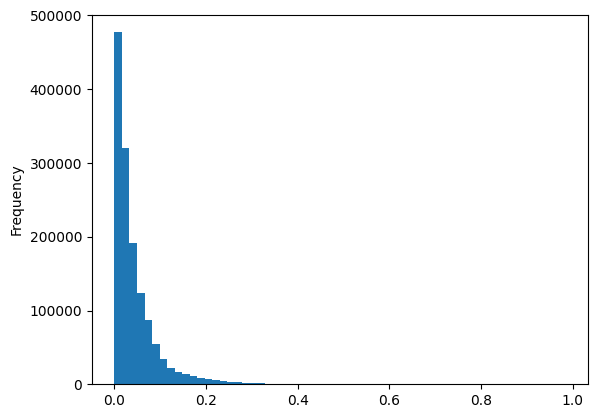

In [21]:
# Plot prediction distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(data=intent_df_preds, x='churned_1_PREDICTION', bins=50)
# sns.histplot(data=intent_df_preds, x='churned_1_PREDICTION', bins=15)
# plt.title('Distribution of Intent Model Predictions')
# plt.show()

intent_df_preds2['churned_1_PREDICTION'].plot.hist(bins=60)

In [22]:
# Analyze target distribution
print("\nIntent Model Target Distribution:")
print(intent_df_preds2['churned'].value_counts(normalize=True))

print("\nChurn Model Target Distribution:")
print(churn_df_preds['true_churned'].value_counts(normalize=True))



Intent Model Target Distribution:
0    0.930678
1    0.069322
Name: churned, dtype: float64

Churn Model Target Distribution:
0    0.975305
1    0.016983
2    0.007713
Name: true_churned, dtype: float64


~7% target rate for Intent model;
~2.5% target rate for Churn model (1+2 combined)

### See Stop intent dates

In [24]:
# Analyze stop intent dates
intent_df_preds2['has_stop_intent'] = intent_df_preds2['stop_intent_date'].notna()
print("\nPercentage of records with stop intent:")
print(f"{intent_df_preds2['has_stop_intent'].mean():.2%}")


Percentage of records with stop intent:
6.93%


In [25]:
# Time analysis for records with stop intent
intent_df_preds2['observation_date'] = pd.to_datetime(intent_df_preds2['observation_date'])
intent_df_preds2['stop_intent_date'] = pd.to_datetime(intent_df_preds2['stop_intent_date'])


In [26]:
mask = intent_df_preds2['stop_intent_date'].notna()
if mask.any():
    intent_df_preds2.loc[mask, 'days_to_intent'] = (
        intent_df_preds2.loc[mask, 'stop_intent_date'] - 
        intent_df_preds2.loc[mask, 'observation_date']
    ).dt.days
    
    print("\nDays to Intent Statistics:")
    print(intent_df_preds2.loc[mask, 'days_to_intent'].describe())


Days to Intent Statistics:
count    96558.000000
mean        29.716792
std         15.665353
min          0.000000
25%         17.000000
50%         31.000000
75%         41.000000
max         60.000000
Name: days_to_intent, dtype: float64


In [37]:
intent_df_preds2[intent_df_preds2.churned_1_PREDICTION > 0.8].days_to_intent.value_counts()

0.0     251
8.0       5
15.0      4
16.0      4
30.0      3
12.0      3
9.0       2
45.0      2
3.0       2
22.0      2
43.0      2
47.0      1
50.0      1
34.0      1
5.0       1
4.0       1
18.0      1
1.0       1
24.0      1
31.0      1
32.0      1
33.0      1
19.0      1
Name: days_to_intent, dtype: int64

In [42]:
from sklearn.metrics import confusion_matrix, classification_report 
confusion_matrix(
                intent_df_preds['churned'],
                intent_df_preds['churned_PREDICTION']
            )

array([[1400304,   91943],
       [  89915,   19595]])

In [43]:
print(classification_report(
    intent_df_preds['churned'],
    intent_df_preds['churned_PREDICTION']
))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94   1492247
           1       0.18      0.18      0.18    109510

    accuracy                           0.89   1601757
   macro avg       0.56      0.56      0.56   1601757
weighted avg       0.89      0.89      0.89   1601757



In [38]:
print(classification_report(
    intent_df_preds2['churned'],
    intent_df_preds2['churned_PREDICTION'].round(0)
))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94   1296343
           1       0.17      0.17      0.17     96558

    accuracy                           0.89   1392901
   macro avg       0.56      0.55      0.55   1392901
weighted avg       0.89      0.89      0.89   1392901



- macro average (averaging the unweighted mean per label). simply calculates the mean of the binary metrics, giving equal weight to each class. In problems where infrequent classes are nonetheless important, macro-averaging may be a means of highlighting their performance. On the other hand, the assumption that all classes are equally important is often untrue, such that macro-averaging will over-emphasize the typically low performance on an infrequent class.
- weighted average (averaging the support-weighted mean per label) - accounts for class imbalance by computing the average of binary metrics in which each class’s score is weighted by its presence in the true data sample.

## Basic EDA of churn model

In [44]:
# Check for duplicates in rule model data
rule_dupes = churn_df_preds.groupby(['idsubscrip', 'inference_date']).size().reset_index(name='count')
print("Records with duplicates in rule model:")
print(rule_dupes[rule_dupes['count'] > 1])

Records with duplicates in rule model:
Empty DataFrame
Columns: [idsubscrip, inference_date, count]
Index: []


In [45]:
# Analyze risk label distribution
print("\nRule Model Risk Label Distribution:")
print(churn_df_preds['risk_label'].value_counts(normalize=True))


Rule Model Risk Label Distribution:
Low         0.650363
Medium      0.285209
Med-High    0.046602
High        0.017826
Name: risk_label, dtype: float64


In [46]:
# Analyze target distribution
print("\nRule Model Target Distribution:")
print(churn_df_preds['true_churned'].value_counts(normalize=True))


Rule Model Target Distribution:
0    0.975305
1    0.016983
2    0.007713
Name: true_churned, dtype: float64


<AxesSubplot: ylabel='Frequency'>

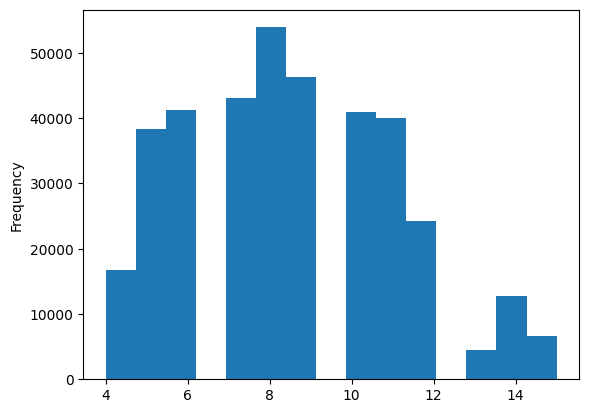

In [47]:
churn_df_preds['bin_sum'].plot.hist(bins=15)

<AxesSubplot: >

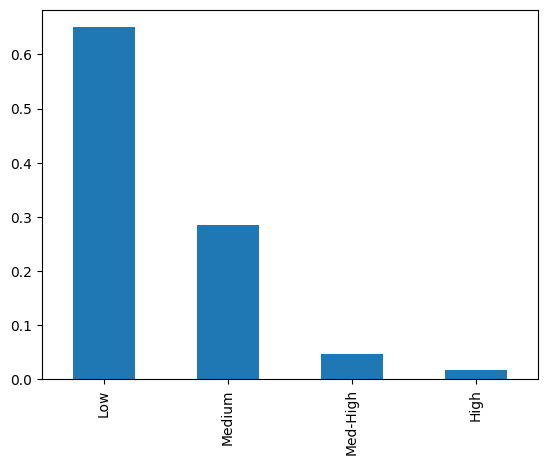

In [53]:
churn_df_preds['risk_label'].value_counts(normalize=True).plot(kind='bar')

In [54]:
# Prepare date columns for merging
churn_df_preds['inference_date'] = pd.to_datetime(churn_df_preds['inference_date'])

In [55]:
churn_df_preds[['true_churned','churn_label']].value_counts(dropna=False)

true_churned  churn_label
0             0              337469
              1               22039
1             0                4830
2             0                2563
1             1                1430
2             1                 280
dtype: int64

In [57]:
print(classification_report(
    churn_df_preds['true_churned'],
    churn_df_preds['churn_label']
))

/etc/system/kernel/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/etc/system/kernel/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
              precision    recall  f1-score   support

           0       0.98      0.94      0.96    359508
           1       0.06      0.23      0.10      6260
           2       0.00      0.00      0.00      2843

    accuracy                           0.92    368611
   macro avg       0.35      0.39      0.35    368611
weighted

In [56]:
print(classification_report(
    np.where(churn_df_preds['true_churned'] >= 1, 1, 0),
    churn_df_preds['churn_label']
))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    359508
           1       0.07      0.19      0.10      9103

    accuracy                           0.92    368611
   macro avg       0.53      0.56      0.53    368611
weighted avg       0.96      0.92      0.94    368611



## Merge predictions

In [58]:
intent_df_preds2.shape, churn_df_preds.shape

((1392901, 15), (368611, 6))

In [59]:
# Merge datasets
merged_df = pd.merge(
    intent_df_preds2,
    churn_df_preds,
    how='outer',
    left_on=['idsubscrip', 'observation_date'],
    right_on=['idsubscrip', 'inference_date']
)

In [60]:
# Analyze merge results
print("Merge Statistics:")
print(f"Total records: {len(merged_df)}")
print(f"Intent model only: {merged_df['true_churned'].isna().sum()}")
print(f"Rule model only: {merged_df['churned'].isna().sum()}")
print(f"Both models: {(merged_df['churned'].notna()&merged_df['true_churned'].notna()).sum()}")

Merge Statistics:
Total records: 1417721
Intent model only: 1049110
Rule model only: 24820
Both models: 343791


In [61]:
merged_df.head()

,idsubscrip,idsystem,pubcode,observation_date,THRESHOLD,POSITIVE_CLASS,DEPLOYMENT_APPROVAL_STATUS,prediction_status,churned,stop_intent_date,has_stop_intent,churned_1_PREDICTION,churned_0_PREDICTION,churned_PREDICTION,days_to_intent,inference_date,bin_sum,risk_label,churn_label,true_churned
0,7950030,153200.0,LC,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.012567,0.987433,0.0,NaN,NaT,NaN,NaN,NaN,NaN
1,7959499,153200.0,LC,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.021388,0.978612,0.0,NaN,NaT,NaN,NaN,NaN,NaN
2,21676859,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.009742,0.990258,0.0,NaN,2024-08-04,5.0,Low,0.0,0.0
3,21676892,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.042350,0.957650,0.0,NaN,NaT,NaN,NaN,NaN,NaN
4,21677007,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.008060,0.991940,0.0,NaN,2024-08-04,7.0,Low,0.0,0.0


#### keep common subscribers

In [62]:
merged_df2 = merged_df[(merged_df['churned'].notna() & merged_df['true_churned'].notna())].copy()

In [63]:
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343791 entries, 2 to 1392900
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   idsubscrip                  343791 non-null  int64         
 1   idsystem                    343791 non-null  float64       
 2   pubcode                     343791 non-null  object        
 3   observation_date            343791 non-null  datetime64[ns]
 4   THRESHOLD                   343791 non-null  float64       
 5   POSITIVE_CLASS              343791 non-null  float64       
 6   DEPLOYMENT_APPROVAL_STATUS  343791 non-null  object        
 7   prediction_status           343791 non-null  object        
 8   churned                     343791 non-null  float64       
 9   stop_intent_date            19833 non-null   datetime64[ns]
 10  has_stop_intent             343791 non-null  object        
 11  churned_1_PREDICTION        343791 non

In [64]:
merged_df2.head()

,idsubscrip,idsystem,pubcode,observation_date,THRESHOLD,POSITIVE_CLASS,DEPLOYMENT_APPROVAL_STATUS,prediction_status,churned,stop_intent_date,has_stop_intent,churned_1_PREDICTION,churned_0_PREDICTION,churned_PREDICTION,days_to_intent,inference_date,bin_sum,risk_label,churn_label,true_churned
2,21676859,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.009742,0.990258,0.0,NaN,2024-08-04,5.0,Low,0.0,0.0
4,21677007,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.008060,0.991940,0.0,NaN,2024-08-04,7.0,Low,0.0,0.0
5,21677200,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.010298,0.989702,0.0,NaN,2024-08-04,4.0,Low,0.0,0.0
6,21677214,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.010679,0.989321,0.0,NaN,2024-08-04,5.0,Low,0.0,0.0
8,21677515,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,False,0.050028,0.949972,0.0,NaN,2024-08-04,8.0,Low,0.0,0.0


In [65]:
merged_df2.churned_PREDICTION.describe()

count    343791.000000
mean          0.077994
std           0.266207
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: churned_PREDICTION, dtype: float64

In [66]:
merged_df2['churned_PREDICTION'] = merged_df2['churned_PREDICTION'].round(0)
merged_df2.churned_PREDICTION.describe()

count    343791.000000
mean          0.076770
std           0.266227
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: churned_PREDICTION, dtype: float64

## Analyze targets alignment

In [67]:
# Analyze target alignment for records with both targets
both_targets = merged_df[['churned', 'true_churned']].dropna()
if len(both_targets) > 0:
    target_agreement = (both_targets['churned'] == both_targets['true_churned']).mean()
    print(f"\nTarget agreement rate: {target_agreement:.2%}")



Target agreement rate: 95.70%


In [68]:
# Analyze prediction alignment
both_preds = merged_df[['churned_PREDICTION', 'churn_label']].dropna()
if len(both_preds) > 0:
    pred_agreement = (both_preds['churned_PREDICTION'] == both_preds['churn_label']).mean()
    print(f"\nPrediction agreement rate: {pred_agreement:.2%}")



Prediction agreement rate: 89.63%


Text(0.5, 1.0, 'Intent Pred Probabilities vs Churn Pred Labels')

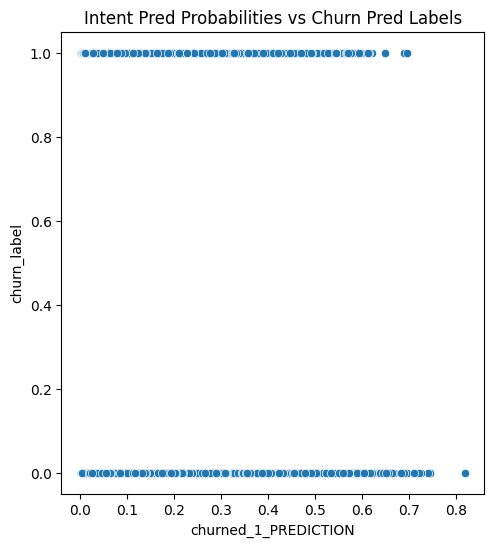

In [69]:
# Visualize prediction agreement
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=merged_df.dropna(subset=['churned_1_PREDICTION', 'churn_label']), 
                x='churned_1_PREDICTION', y='churn_label')
plt.title('Intent Pred Probabilities vs Churn Pred Labels')


Text(0.5, 1.0, 'Intent Pred Labels vs Churn Pred Labels')

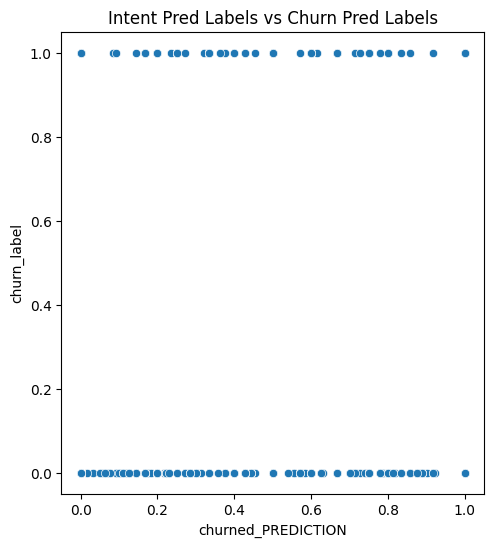

In [70]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=merged_df.dropna(subset=['churned_PREDICTION', 'churn_label']), 
                x='churned_PREDICTION', y='churn_label')
plt.title('Intent Pred Labels vs Churn Pred Labels')

In [71]:
merged_df.columns

Index(['idsubscrip', 'idsystem', 'pubcode', 'observation_date', 'THRESHOLD',
       'POSITIVE_CLASS', 'DEPLOYMENT_APPROVAL_STATUS', 'prediction_status',
       'churned', 'stop_intent_date', 'has_stop_intent',
       'churned_1_PREDICTION', 'churned_0_PREDICTION', 'churned_PREDICTION',
       'days_to_intent', 'inference_date', 'bin_sum', 'risk_label',
       'churn_label', 'true_churned'],
      dtype='object')

#### See true churns with stop and no stop intent

In [74]:
merged_df.groupby('true_churned')['has_stop_intent'].value_counts()

true_churned  has_stop_intent
0.0           False              323915
              True                14739
1.0           True                 5094
              False                  43
Name: has_stop_intent, dtype: int64

In [75]:
merged_df.groupby('true_churned')['has_stop_intent'].value_counts(normalize=True)

true_churned  has_stop_intent
0.0           False              0.956478
              True               0.043522
1.0           True               0.991629
              False              0.008371
Name: has_stop_intent, dtype: float64

<1% of churns didn't have stop intents <br>
<b>~4.3% had and intent within 60 days but didn't churn within 30 days<br> 

In [77]:
merged_df[(merged_df.has_stop_intent == True) & merged_df.true_churned == 1]['days_to_intent'].value_counts()

9.0     699
1.0     328
15.0    264
5.0     264
12.0    261
10.0    247
2.0     244
8.0     242
11.0    224
16.0    218
4.0     211
3.0     211
19.0    191
18.0    151
22.0    149
25.0    146
23.0    128
17.0    128
26.0    127
14.0     99
24.0     98
13.0     85
6.0      74
21.0     56
20.0     50
7.0      44
27.0     39
28.0     39
30.0     36
29.0     33
0.0       3
31.0      1
36.0      1
33.0      1
46.0      1
37.0      1
Name: days_to_intent, dtype: int64

In [80]:
merged_df[merged_df.has_stop_intent==True].groupby(['true_churned'])['days_to_intent'].describe()

,count,mean,std,min,25%,50%,75%,max
true_churned,,,,,,,,
0.0,14739.0,35.968587,15.921900,0.0,24.0,39.0,49.0,60.0
1.0,5094.0,12.011582,7.577731,0.0,6.0,10.0,17.0,46.0


In [83]:
# Analyze misaligned targets/ labels days_to_intent
both_preds2 = merged_df[['churned', 'true_churned', 'days_to_intent']].dropna()
# both_preds2 = both_preds2[both_preds2.churned != both_preds2.churn_label]
# if len(both_preds2) > 0:
#     pred_agreement = (both_preds['churned'] == both_preds['churn_label']).mean()
#     print(f"\nPrediction agreement rate: {pred_agreement:.2%}")
print("Distribution of days to intent for misaligned true labels")
print(both_preds2[both_preds2.churned != both_preds2.true_churned].days_to_intent.describe())
print("Distribution of days to intent for aligned true labels")
print(both_preds2[both_preds2.churned == both_preds2.true_churned].days_to_intent.describe())
print("overall")
print(merged_df['days_to_intent'].describe())

Distribution of days to intent for misaligned true labels
count    14739.000000
mean        35.968587
std         15.921900
min          0.000000
25%         24.000000
50%         39.000000
75%         49.000000
max         60.000000
Name: days_to_intent, dtype: float64
Distribution of days to intent for aligned true labels
count    5094.000000
mean       12.011582
std         7.577731
min         0.000000
25%         6.000000
50%        10.000000
75%        17.000000
max        46.000000
Name: days_to_intent, dtype: float64
overall
count    96558.000000
mean        29.716792
std         15.665353
min          0.000000
25%         17.000000
50%         31.000000
75%         41.000000
max         60.000000
Name: days_to_intent, dtype: float64


In [85]:
# Analyze misaligned targets/ labels days_to_intent
both_preds2 = merged_df[['churned_PREDICTION', 'churn_label', 'days_to_intent']].dropna()
print("Distribution of days to intent for misaligned PREDICTED labels, aligned PREDICTED labels and overall")
print(both_preds2[both_preds2.churned_PREDICTION != both_preds2.churn_label].days_to_intent.describe())
print(both_preds2[both_preds2.churned_PREDICTION == both_preds2.churn_label].days_to_intent.describe())
print(merged_df['days_to_intent'].describe())

Distribution of days to intent for misaligned PREDICTED labels, aligned PREDICTED labels and overall
count    4954.000000
mean       30.824990
std        17.421899
min         0.000000
25%        15.000000
50%        31.000000
75%        45.000000
max        60.000000
Name: days_to_intent, dtype: float64
count    14879.000000
mean        29.479199
std         17.757147
min          1.000000
25%         12.000000
50%         29.000000
75%         45.000000
max         60.000000
Name: days_to_intent, dtype: float64
count    96558.000000
mean        29.716792
std         15.665353
min          0.000000
25%         17.000000
50%         31.000000
75%         41.000000
max         60.000000
Name: days_to_intent, dtype: float64


# Comparison of models: ML and Business Analysis
## Import utils

In [101]:
import importlib
import sys
import evaluation_utils
importlib.reload(sys.modules['evaluation_utils'])
from evaluation_utils import ChurnModelEvaluator, ChurnAnalyzer

INTENT_WINDOW = 60  # days
CHURN_WINDOW = 30  # days
COMMON_WINDOW = min(INTENT_WINDOW, CHURN_WINDOW)

## Run evaluation

In [87]:
# merged_df2['churn_date_col'] = merged_df2[''] + pd.Timedelta(days=CHURN_WINDOW)
merged_df2['has_intent'] = merged_df2['stop_intent_date'].notna()

In [88]:
# Initialize evaluator with correct column mappings
evaluator = ChurnModelEvaluator(
    pred_date_col='observation_date',
    intent_target_col='churned',
    churn_target_col='true_churned',
    intent_score_col='churned_1_PREDICTION',
    churn_score_col='churn_label',
    intent_date_col='stop_intent_date',
    intent_pred_label='churned_PREDICTION',
    churn_pred_label='churn_label', #same
    segment_cols=['pubcode']
)

In [89]:
merged_df2.head()

,idsubscrip,idsystem,pubcode,observation_date,THRESHOLD,POSITIVE_CLASS,DEPLOYMENT_APPROVAL_STATUS,prediction_status,churned,stop_intent_date,...,churned_1_PREDICTION,churned_0_PREDICTION,churned_PREDICTION,days_to_intent,inference_date,bin_sum,risk_label,churn_label,true_churned,has_intent
2,21676859,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,...,0.009742,0.990258,0.0,NaN,2024-08-04,5.0,Low,0.0,0.0,False
4,21677007,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,...,0.008060,0.991940,0.0,NaN,2024-08-04,7.0,Low,0.0,0.0,False
5,21677200,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,...,0.010298,0.989702,0.0,NaN,2024-08-04,4.0,Low,0.0,0.0,False
6,21677214,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,...,0.010679,0.989321,0.0,NaN,2024-08-04,5.0,Low,0.0,0.0,False
8,21677515,112000.0,WA,2024-08-04,0.1211,1.0,APPROVED,OK,0.0,NaT,...,0.050028,0.949972,0.0,NaN,2024-08-04,8.0,Low,0.0,0.0,False


In [91]:
merged_df2[['churned','churned_PREDICTION']].value_counts()

churned  churned_PREDICTION
0.0      0.0                   302869
         1.0                    21089
1.0      0.0                    14529
         1.0                     5304
dtype: int64

In [110]:
merged_df2['churned'].mean()

0.05768911926141173

In [90]:
# Get basic model performance
metrics = evaluator.evaluate_models(merged_df2)
print("Model Performance:")
print("\nIntent Model:")
print(metrics['intent']['classification_report'])
print("\nRule Model:")
print(metrics['rule']['classification_report'])

Model Performance:

Intent Model:
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    323958
         1.0       0.20      0.27      0.23     19833

    accuracy                           0.90    343791
   macro avg       0.58      0.60      0.59    343791
weighted avg       0.91      0.90      0.90    343791


Rule Model:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    338654
         1.0       0.05      0.19      0.07      5137

    accuracy                           0.93    343791
   macro avg       0.52      0.57      0.52    343791
weighted avg       0.97      0.93      0.95    343791



In [92]:
merged_df2.columns

Index(['idsubscrip', 'idsystem', 'pubcode', 'observation_date', 'THRESHOLD',
       'POSITIVE_CLASS', 'DEPLOYMENT_APPROVAL_STATUS', 'prediction_status',
       'churned', 'stop_intent_date', 'has_stop_intent',
       'churned_1_PREDICTION', 'churned_0_PREDICTION', 'churned_PREDICTION',
       'days_to_intent', 'inference_date', 'bin_sum', 'risk_label',
       'churn_label', 'true_churned', 'has_intent'],
      dtype='object')

In [0]:
# # Analyze segments
# segment_metrics = evaluator.analyze_segments(merged_df2)
# print("\nSegment Analysis (by pubcode):")
# for pubcode, metrics in segment_metrics['pubcode'].items():
#     print(f"\n\tPublication {pubcode}:")
#     for metric, value in metrics.items():
#         print(f"\t\t{metric}: {value:.3f}")

### Segments by pubcode

In [93]:
# Analyze segments
segment_metrics = evaluator.analyze_segments(merged_df2)
print("\nSegment Analysis (by pubcode):")
for pubcode, metrics in segment_metrics['pubcode'].items():
    print(f"\n\tPublication {pubcode}:")
    for metric, value in metrics.items():
        print(f"\t\t{metric}: {value:.3f}")


Segment Analysis (by pubcode):

	Publication WA:
		size: 18585.000
		intent_auc: 0.555
		intent_precision: 0.206
		rule_precision: 0.051

	Publication DA:
		size: 70674.000
		intent_auc: 0.707
		intent_precision: 0.211
		rule_precision: 0.049

	Publication SD:
		size: 6549.000
		intent_auc: 0.716
		intent_precision: 0.199
		rule_precision: 0.055

	Publication DP:
		size: 14946.000
		intent_auc: 0.756
		intent_precision: 0.216
		rule_precision: 0.035

	Publication DF:
		size: 2945.000
		intent_auc: 0.640
		intent_precision: 0.176
		rule_precision: 0.047

	Publication DG:
		size: 10272.000
		intent_auc: 0.724
		intent_precision: 0.164
		rule_precision: 0.031

	Publication CD:
		size: 10780.000
		intent_auc: 0.703
		intent_precision: 0.164
		rule_precision: 0.050

	Publication ZA:
		size: 3969.000
		intent_auc: 0.797
		intent_precision: 0.231
		rule_precision: 0.045

	Publication ZG:
		size: 4234.000
		intent_auc: 0.788
		intent_precision: 0.179
		rule_precision: 0.043

	Publication ME:


### False positive analysis

Interpreation of False Positives:

Subscriber Impact:
- Each false positive means we're intervening with a subscriber who wasn't actually going to churn
- This could lead to unnecessary contact/offers that might:
  - Annoy loyal subscribers
  - Create awareness about better offers they weren't considering
  - Make them question their current subscription


Resource Impact:
- Each intervention costs money (agent time, offers, promos)
- False positives represent wasted resources
- Higher false positive rates in certain segments might indicate where the model needs improvement

In [71]:
# Analyze false positives


fp_analysis = evaluator.analyze_false_positives(merged_df2)
print("\nFalse Positive Analysis:")
print(f"Intent Model FP Rate: {fp_analysis['intent']['fp_rate']:.3f}")
print(f"Rule Model FP Rate: {fp_analysis['rule']['fp_rate']:.3f}")


False Positive Analysis:
Intent Model FP Rate: 0.061
Rule Model FP Rate: 0.060


In [160]:
# intent_analysis = evaluator.analyze_intention_patterns(merged_df2)
# print("\nIntention Pattern Analysis:")
# print(f"Churn rate with intention: {intent_analysis['intent_to_churn']['intent_churn_rate']:.3f}")
# print(f"Churn rate without intention: {intent_analysis['intent_to_churn']['no_intent_churn_rate']:.3f}")


### Basic business impact analysis on all subscribers

Meaning of Impact Analysis:

1. Cost Structure:
- Intervention Costs, e.g.
    - Agent time/salary
    - Retention offers/discounts
    - System resources


- Revenue Implications, e.g.
    - Saved revenue from retained customers
    - Lost revenue from unnecessary discounts
    - Lifetime value impact

2. ROI Components:
- True Positives (Successful Interventions), e.g.
   - Revenue saved from accurately predicted and prevented churns
   - Strengthened customer relationships
   - Potential for positive word-of-mouth

- False Positives (Unnecessary Interventions), e.g.
   - Wasted intervention costs
   - Potential negative customer experience
   - Unnecessary discounts given

cost_per_true_positive - How much we spend to save one customer

In [94]:
# Calculate business impact
business_impact = evaluator.calculate_business_impact(
    merged_df2,
    cost_per_intervention=10, 
    revenue_per_save=100
)
print("\nBusiness Impact Analysis:")
for model, impact in business_impact.items():
    print(f"\n{model.capitalize()} Model:")
    for metric, value in impact.items():
        print(f"\t{metric}: {value}")


Business Impact Analysis:

Intent Model:
	interventions: 26393.0
	true_positives: 5304
	false_positives: 21089
	total_cost: 263930.0
	total_benefit: 530400
	roi: 1.0096237638767855
	cost_per_true_positive: 49.7605580693816

Churn Model:
	interventions: 21595.0
	true_positives: 986
	false_positives: 20609
	total_cost: 215950.0
	total_benefit: 98600
	roi: -0.5434128270432971
	cost_per_true_positive: 219.01622718052738


##### TODO: run analysis using churn truetarget for intent model predictions

In [96]:
# TODO:

## Cost-Benefit analysis


Run on top N percent of predictions
Based on:
- P(prevent | given(TP+FP))
- Customer value
- Cost of intervention
- (additional value could be added, e.g. intervention leads to upsell)

Different retention scenarios based on input:
- base: cost as defined, success_rate as defined, additional_value=0
- optimistic: cost=100%, success_rate+25%, additional_value=10% of customer_value
- pessimistic: cost=100%, success_rate-25%

In [98]:
analyzer = ChurnAnalyzer(
    intervention_success_rate=0.5,  # 50% chance to prevent churn
    customer_value=8*12,           # $8 average cost times 12 month - customer value
    intervention_cost=9,          # $9 intervention cost, e.g. assuming 30min time needed and 18$ average hourly rate for call center
    retention_program='base',
    top_n_percent=10,
)


- intervention_rate: (TP+FP) / N
- ROI: (saved_revenue + additional_revenue - intervention_costs - wasted_costs) / (intervention_costs + wasted_costs)

In [99]:
results = analyzer.calculate_costs_benefits(merged_df2)

# Print summary
for model_name, analysis in results.items():
    print(f"\n{model_name.upper()} MODEL ANALYSIS")
    print("\nConfusion Matrix:")
    for k, v in analysis['confusion_matrix'].items():
        print(f"\t{k}: {v}")
    print("\nMetrics:")
    for k, v in analysis['metrics'].items():
        print(f"\t{k}: {v:.3f}")
        
    print("\nFinancial Impact:")
    for k, v in analysis['financial_impact'].items():
        print(f"\t{k}: ${v:,.2f}")

# # Optimize thresholds
# best_thresholds, best_impacts = analyzer.optimize_thresholds(df)
# print("\nOptimal Thresholds:")
# for segment, threshold in best_thresholds.items():
#     print(f"{segment}: {threshold:.2f} (Net Impact: ${best_impacts[segment]:,.2f})")



CHURN_MODEL MODEL ANALYSIS

Confusion Matrix:
	TP: 986
	FP: 20609
	TN: 12403
	FN: 381

Metrics:
	precision: 0.046
	recall: 0.721
	intervention_rate: 0.628

Financial Impact:
	saved_revenue: $47,328.00
	additional_revenue: $0.00
	intervention_costs: $8,874.00
	wasted_costs: $185,481.00
	missed_revenue: $36,576.00
	net_impact: $-183,603.00
	roi: $-0.76

INTENT_MODEL MODEL ANALYSIS

Confusion Matrix:
	TP: 5304
	FP: 21088
	TN: 7060
	FN: 927

Metrics:
	precision: 0.201
	recall: 0.851
	intervention_rate: 0.768

Financial Impact:
	saved_revenue: $254,592.00
	additional_revenue: $0.00
	intervention_costs: $47,736.00
	wasted_costs: $189,792.00
	missed_revenue: $88,992.00
	net_impact: $-71,928.00
	roi: $0.07


In [235]:
# # prioritized_df = analyzer.prioritize_interventions(df)

# results = analyzer.analyze_intervention_strategy(merged_df2)

# # Print analysis results
# for model, analysis in results.items():
#     print(f"\n{model.upper()} MODEL - Top {analyzer.top_n_percent}% Strategy")
#     print("\n\tIntervention Metrics:")
#     for metric, value in analysis['metrics'].items():
#         print(f"\t\t{metric}: {value:,.2f}")
    
#     print("\n\tFinancial Impact:")
#     for metric, value in analysis['financial'].items():
#         print(f"\t\t{metric}: ${value:,.2f}")

###  use true_churn as target for intent model

In [108]:
analyzer2 = ChurnAnalyzer(         
    intervention_success_rate=0.5,  # 50% chance to prevent churn
    customer_value=8*12,           # $8 average cost times 12 month - customer value
    intervention_cost=9,          # $9 intervention cost, e.g. assuming 30min time needed and 18$ average hourly rate for call center
    retention_program='base',
    top_n_percent=10,
    intent_target_col='true_churned', #target for intentmodel = target for churn model
)

In [109]:
results2 = analyzer2.calculate_costs_benefits(merged_df2)

# Print summary
for model_name, analysis in results2.items():
    print(f"\n{model_name.upper()} MODEL ANALYSIS")
    print("\nConfusion Matrix:")
    for k, v in analysis['confusion_matrix'].items():
        print(f"\t{k}: {v}")
    print("\nMetrics:")
    for k, v in analysis['metrics'].items():
        print(f"\t{k}: {v:.3f}")
        
    print("\nFinancial Impact:")
    for k, v in analysis['financial_impact'].items():
        print(f"\t{k}: ${v:,.2f}")


CHURN_MODEL MODEL ANALYSIS

Confusion Matrix:
	TP: 986
	FP: 20609
	TN: 12403
	FN: 381

Metrics:
	precision: 0.046
	recall: 0.721
	intervention_rate: 0.628

Financial Impact:
	saved_revenue: $47,328.00
	additional_revenue: $0.00
	intervention_costs: $8,874.00
	wasted_costs: $185,481.00
	missed_revenue: $36,576.00
	net_impact: $-183,603.00
	roi: $-0.76

INTENT_MODEL MODEL ANALYSIS

Confusion Matrix:
	TP: 1428
	FP: 24964
	TN: 7749
	FN: 238

Metrics:
	precision: 0.054
	recall: 0.857
	intervention_rate: 0.768

Financial Impact:
	saved_revenue: $68,544.00
	additional_revenue: $0.00
	intervention_costs: $12,852.00
	wasted_costs: $224,676.00
	missed_revenue: $22,848.00
	net_impact: $-191,832.00
	roi: $-0.71


In [105]:
analyzer2.intent_target_col,analyzer2.intent_target_col


('true_churned', 'true_churned')

Future work and improvements:
- validate assumptions
- include date to churn into analysis; days to churn vs days to intent
- segmentation by customer value/tenure
- analyse intervention timing/window
- targets misalignment issue: intion to stop target window is 60 days, churn window is 30 days. If intention to stop is at date T, we predict at T-60, would churn usually be at date X that is always strictly > T
- error analysis by segment? some pubcodes are very good some are disaster
- How can we combine and both models?
- analyze prediction-to-intervention time lag

In [0]:
# 1. Model Performance Comparison
model_comparison = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score', 'ROI', 'Cost per True Positive'],
        'Intent Model': [0.20, 0.27, 0.23, 1.00, '$49'],
        'Churn Rules Model': [0.046, 0.72, 0.07, -0.54, '$219']
})

# 2. Business Impact Summary
    business_impact = pd.DataFrame({
        'Metric': ['Total Interventions', 'True Positives', 'False Positives', 
                  'Total Cost', 'Total Benefit', 'Net Impact'],
        'Intent Model': [26393, 5304, 21089, '$264K', '$530K', '$266K'],
        'Churn Rules Model': [21595, 986, 20609, '$216K', '$99K', '-$117K']
    })

# 3. Top Performing Segments
    top_segments = pd.DataFrame({
        'Pubcode': ['ZJ', 'ZA', 'ZG', 'DP', 'IC'],
        'Intent AUC': [0.802, 0.797, 0.788, 0.756, 0.761],
        'Intent Precision': [0.212, 0.231, 0.179, 0.216, 0.217],
        'Churn Rules Precision': [0.057, 0.045, 0.043, 0.035, 0.047]
    })

In [0]:
# 1. Model Performance Comparison
model_comparison = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score', 'ROI', 'Cost per True Positive'],
        'Intent Model': [0.20, 0.27, 0.23, 1.00, '$49'],
        'Churn Rules Model': [0.05, 0.19, 0.07, -0.54, '$219']
})

# 2. Business Impact Summary
    business_impact = pd.DataFrame({
        'Metric': ['Total Interventions', 'True Positives', 'False Positives', 
                  'Total Cost', 'Total Benefit', 'Net Impact'],
        'Intent Model': [26393, 5304, 21089, '$264K', '$530K', '$266K'],
        'Churn Rules Model': [21595, 986, 20609, '$216K', '$99K', '-$117K']
    })

# 3. Top Performing Segments
    top_segments = pd.DataFrame({
        'Pubcode': ['ZJ', 'ZA', 'ZG', 'DP', 'IC'],
        'Intent AUC': [0.802, 0.797, 0.788, 0.756, 0.761],
        'Intent Precision': [0.212, 0.231, 0.179, 0.216, 0.217],
        'Churn Rules Precision': [0.057, 0.045, 0.043, 0.035, 0.047]
    })

In [0]:
Business Impact Analysis:
Intent Model:
	interventions: 26393.0
	true_positives: 5304
	false_positives: 21089
	total_cost: 263930.0
	total_benefit: 530400
	roi: 1.0096237638767855
	cost_per_true_positive: 49.7605580693816
Churn Model:
	interventions: 21595.0
	true_positives: 986
	false_positives: 20609
	total_cost: 215950.0
	total_benefit: 98600
	roi: -0.5434128270432971
	cost_per_true_positive: 219.01622718052738

In [0]:
Model Performance:
Intent Model:
              precision    recall  f1-score   support
         0.0       0.95      0.93      0.94    323958
         1.0       0.20      0.27      0.23     19833
    accuracy                           0.90    343791
   macro avg       0.58      0.60      0.59    343791
weighted avg       0.91      0.90      0.90    343791

Rule Model:
              precision    recall  f1-score   support
         0.0       0.99      0.94      0.96    338654
         1.0       0.05      0.19      0.07      5137
    accuracy                           0.93    343791
   macro avg       0.52      0.57      0.52    343791
weighted avg       0.97      0.93      0.95    343791